In [36]:
import numpy as np 
import cv2 as cv 
import matplotlib.pyplot as plt
from utils.edge_extraction import extract_interpolation_region

In [4]:
img = cv.imread("5.34.33.png")
img = cv.cvtColor(img, cv.COLOR_BGR2HSV)

Magnitude = $\sqrt{g_x^2 + g_y^2}$ <br>
Angles = $\arctan2\left(\frac{g_x}{g_y}\right) \times \left( \frac{180}{\pi} \right)$

In [38]:
def compute_gradient_per_channel(input_img: np.ndarray, combine: str = "max") -> (np.ndarray, np.ndarray):
    """
    Compute gradients for each channel of the input image and combine them based on the specified method.

    Args:
        input_img (np.ndarray): Input image as a NumPy array.
        combine (str, optional): Method to combine gradients for each channel.
                                  - "max": Take the maximum gradient among all channels.
                                  - "mean": Take the mean gradient among all channels.
                                  - "sum": Sum the gradients across all channels.
                                  - "median": Take the median gradient among all channels.
                                  Defaults to "max".

    Returns:
        tuple: A tuple containing:
               - gx (np.ndarray): Gradient along the x-axis.
               - gy (np.ndarray): Gradient along the y-axis.

    Raises:
        ValueError: If an invalid combine method is provided.
    """       
    r, g, b = cv.split(input_img)
    
    gx_r, gy_r = np.gradient(r)
    gx_g, gy_g = np.gradient(g)
    gx_b, gy_b = np.gradient(b)
    
    if combine == "max":
        gx = np.maximum.reduce([gx_r, gx_b, gx_g])
        gy = np.maximum.reduce([gy_r, gy_b, gy_g])
    elif combine == "mean":
        gx = np.mean([gx_r, gx_b, gx_g])
        gy = np.mean([gy_r, gy_b, gy_g])
    elif combine == "sum":
        gx = np.sum([gx_r, gx_b, gx_g])
        gy = np.sum([gy_r, gy_b, gy_g])
    elif combine == "median":
        gx = np.median([gx_r, gx_b, gx_g])
        gy = np.median([gy_r, gy_b, gy_g])
    else:
        raise ValueError("Invalid combine method. Choose between 'max', 'mean', 'sum', and 'median'.")
        
    return gx, gy


In [39]:
def generate_angular_hist(input_img: np.ndarray, n_bins: int = 9, _n: int = 20, combine: str = "max", normalize: bool = True) -> (np.ndarray, np.ndarray):
    """
    Generate Angular Histogram features from an input image.

    Args:
        input_img (np.ndarray): Input image as a NumPy array.
        n_bins (int, optional): Number of bins in the histogram. Defaults to 9.
        _n (float, optional): Percentage of pixels to select among the total pixels with the largest magnitude values. Defaults to 20%.
        combine (str, optional): Method to combine gradients for each channel.
                                  - "max": Take the maximum gradient among all channels.
                                  - "mean": Take the mean gradient among all channels.
                                  - "sum": Sum the gradients across all channels.
                                  - "median": Take the median gradient among all channels.
        normalize (bool, optional): Whether to normalize the histogram. Defaults to True.

    Returns:
        tuple: A tuple containing:
               - hist (np.ndarray): The computed histogram of oriented gradients.
               - top_mags (np.ndarray): The magnitudes of the top 'n' pixels.
    """
    angle_step = 180 / n_bins
    bins = np.arange(0, 180, angle_step)
    
    if len(input_img.shape) > 2:
        gx, gy = compute_gradient_per_channel(input_img[:,:,:3], combine=combine)
    else:
        gx, gy = np.gradient(input_img)
        
    mag = np.hypot(gx, gy)  # Magnitudes
    angles = np.rad2deg(np.arctan2(gy, gx))  # Angles
    
    N = input_img.shape[0] * input_img.shape[1]
    n = N * _n // 100
    
    # Select top 'n' pixels with the largest magnitude values
    sorted_indices = np.argsort(mag)[::-1]  # Sort indices in descending order
    top_mags = mag.ravel()[sorted_indices[:n]]
    top_angles = angles.ravel()[sorted_indices[:n]]
    
    # Create histogram 
    hist, _ = np.histogram(top_angles, bins=bins, range=(0, 180))
    # Inserts a value of 0 at index 0 of the hist array to ensure all bins are represented
    hist = np.insert(hist, 0, 0)[:n_bins] 
    hist = hist.astype(float)
    
    # Normalize the histogram
    if normalize:
        hist /= np.sum(hist)
    
    return hist, top_mags


# Histogram of Oriented Gradients

Number of bins = ranging from 0° to 180° degrees <br>
Angle step size ($\Delta\theta$) = 180° / Number of bins

Each bin will have an interval ranging from
$$
\begin{aligned}
    [ \Delta\theta \cdot j, \Delta\theta \cdot (j + 1) ]
\end{aligned}
$$

In [40]:
def calculate_dft(input_signal: np.ndarray) -> np.ndarray:
    """
    Calculates the 1D Discrete Fourier Transform (DFT) of a 1D signal.

    Args:
    - input_img (np.ndarray): Input signal as a 1D numpy array.

    Returns:
    - ft (np.ndarray): 1D DFT of the input signal, Fourier coefficients shifted to the center.

    This function computes the 2D DFT of the input image using numpy's fft.fft() function.
    The resulting DFT coefficients are shifted to center the low frequencies.
    """
    ft = np.fft.fft(input_signal)
    return np.fft.fftshift(ft)


def calculate_idft(input_img: np.ndarray) -> np.ndarray:
    """
    Calculates the 1D Inverse Discrete Fourier Transform (IDFT) of a 1D signal.

    Args:
    - input_img (np.ndarray): Input signal as a 1D numpy array.

    Returns:
    - ifft (np.ndarray): 1D IDFT of the input signal, real part of the inverse transform.

    This function computes the 1D IDFT of the input image using numpy's fft.ifft() function.
    The input signal is expected to have been shifted to center the low frequencies.
    """
    ifft = np.fft.ifftshift(input_img)
    return np.fft.ifft(ifft).real


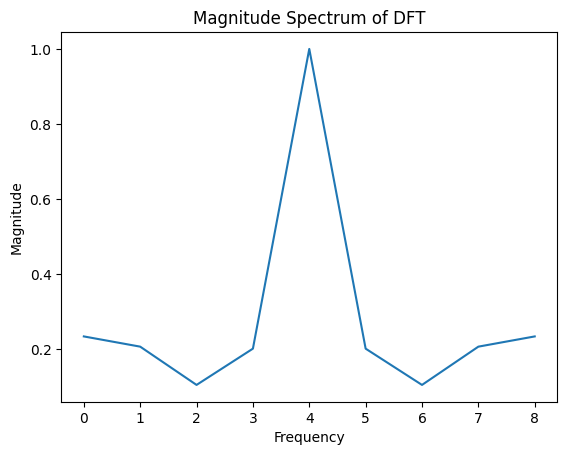

In [141]:
hist_dft = calculate_dft(generate_angular_hist(img)[0])
magnitudes_spectrum = np.abs(hist_dft) # will be served as feature vector

plt.plot(magnitudes_spectrum)
plt.xlabel('Frequency')
plt.ylabel('Magnitude')
plt.title('Magnitude Spectrum of DFT')
plt.show()

In [16]:
import numpy as np
import cv2
from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt

def compare_images(image1, image2, dist='euclidean'):
    h1, m1 = generate_angular_hist(image1)
    h2, m2 = generate_angular_hist(image2)
    
    # perform dft on the angular histogram to get the rotate invariance property
    h1_dft = calculate_dft(h1)
    h2_dft = calculate_dft(h2)
    
    h1_magnitudes_spectrum = np.abs(h1_dft)
    h2_magnitudes_spectrum = np.abs(h2_dft)
    
    sim_scores = 1 - pairwise_distances([h1_magnitudes_spectrum, h2_magnitudes_spectrum], metric=dist)
    print(f"Similarity Score: {sim_scores[0][1]}")
    
img1 = cv2.imread("5.34.33.png", flags=cv.IMREAD_UNCHANGED)
region1 = extract_interpolation_region(img1, 5)
# img1 = cv.cvtColor(img1, cv.COLOR_BGR2HSV)
img2 = cv2.imread("5.34.5.png", flags=cv.IMREAD_UNCHANGED)
region2 = extract_interpolation_region(img2, 5)
# img2 = cv.cvtColor(img2, cv.COLOR_BGR2HSV)

In [66]:
img1 = cv.imread("5.34.33.png", flags=cv.IMREAD_UNCHANGED)
print(img1)
img1.shape

[[[ 62 128 109   0]
  [ 43 109  90   0]
  [ 58 120 102   0]
  ...
  [181 224 233   0]
  [172 218 229   0]
  [172 217 230   0]]

 [[ 59 125 106   0]
  [ 64 130 111   0]
  [ 65 129 110   0]
  ...
  [172 209 217   0]
  [167 208 217   0]
  [188 226 238   0]]

 [[ 68 137 117   0]
  [ 86 152 133   0]
  [ 60 124 105   0]
  ...
  [180 209 216   0]
  [178 210 216   0]
  [206 235 244   0]]

 ...

 [[ 79 144 105   0]
  [ 85 151 109   0]
  [ 78 145 100 251]
  ...
  [111 176 161 251]
  [ 60 124 112 251]
  [ 72 133 123 251]]

 [[ 71 135  99   0]
  [ 82 148 107   0]
  [ 71 138  93 251]
  ...
  [ 78 143 128 251]
  [ 64 126 114 251]
  [ 85 145 134 251]]

 [[ 79 145 110   0]
  [100 167 128   0]
  [ 89 158 115 251]
  ...
  [ 72 134 120 251]
  [ 80 142 128 251]
  [ 93 154 140 251]]]


(137, 123, 4)

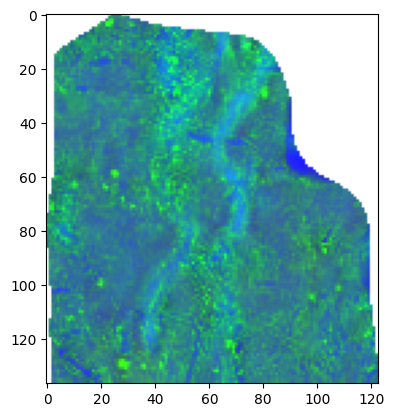

(137, 123, 4)
[[[ 39 131 128   0]
  [ 39 154 109   0]
  [ 39 132 120   0]
  ...
  [ 25  57 233   0]
  [ 24  63 229   0]
  [ 23  64 230   0]]

 [[ 39 135 125   0]
  [ 39 129 130   0]
  [ 39 127 129   0]
  ...
  [ 25  53 217   0]
  [ 25  59 217   0]
  [ 23  54 238   0]]

 [[ 39 128 137   0]
  [ 39 111 152   0]
  [ 39 132 124   0]
  ...
  [ 24  43 216   0]
  [ 25  45 216   0]
  [ 23  40 244   0]]

 ...

 [[ 48 115 144   0]
  [ 49 111 151   0]
  [ 50 118 145 251]
  ...
  [ 37  94 176 251]
  [ 36 132 124 251]
  [ 35 117 133 251]]

 [[ 47 121 135   0]
  [ 49 114 148   0]
  [ 50 124 138 251]
  ...
  [ 37 116 143 251]
  [ 36 125 126 251]
  [ 36 106 145 251]]

 [[ 46 116 145   0]
  [ 47 102 167   0]
  [ 49 111 158 251]
  ...
  [ 37 118 134 251]
  [ 37 111 142 251]
  [ 37 101 154 251]]]


In [67]:
def custom_alpha_hsv(input_image):
    b, g, r, a = cv.split(input_image)
    bgr_image = cv.merge((b, g, r))
    hsv_image = cv.cvtColor(bgr_image, cv.COLOR_BGR2HSV)
    return cv.merge((hsv_image, a))

img1 = cv.imread("5.34.33.png", flags=cv.IMREAD_UNCHANGED)
img1 = custom_alpha_hsv(img1)
plt.imshow(img1)
plt.show()

print(img1.shape)
print(img1)

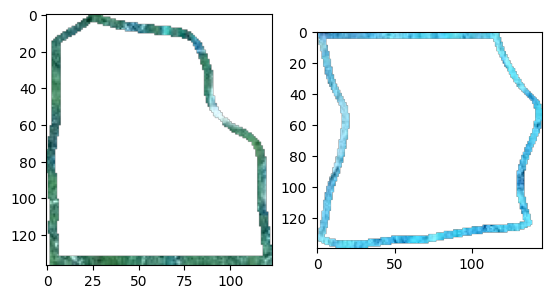

In [17]:
plt.subplot(1, 2, 1)
plt.imshow(region1)
plt.subplot(1, 2, 2)
plt.imshow(region2)
plt.show()

In [18]:
compare_images(image1=region1, image2=region2, dist='euclidean')

Similarity Score: -1.019860914614588


In [68]:
from sklearn.cluster import AgglomerativeClustering
import os
from sklearn.metrics import pairwise_distances

# Specify the directory path
directory = './data/test'

# List all files in the directory
files = os.listdir(directory)

list_magnitudes = []

# Iterate through each file and read its content
for file in files:
    file_path = os.path.join(directory, file)
    img = cv.imread(file_path, cv.IMREAD_UNCHANGED)
    img = custom_alpha_hsv(img)
    h1, m1 = generate_angular_hist(extract_interpolation_region(img))
    # perform dft on the angular histogram to get the rotate invariance property
    h1_dft = calculate_dft(h1)
    h1_magnitudes_spectrum = np.abs(h1_dft)
    list_magnitudes.append(h1_magnitudes_spectrum)

In [69]:
list_magnitudes = np.array(list_magnitudes)

In [56]:
# don't touch - without extrapolation region
clustering = AgglomerativeClustering(n_clusters=5)
cluster = clustering.fit(list_magnitudes)
cluster.labels_

array([3, 1, 3, 1, 0, 4, 0, 2, 1, 0, 2, 1, 2, 1, 3, 0, 0, 2, 2, 4, 0],
      dtype=int64)

In [72]:
clustering = AgglomerativeClustering(n_clusters=5)
cluster = clustering.fit(list_magnitudes)
cluster.labels_

numpy.ndarray

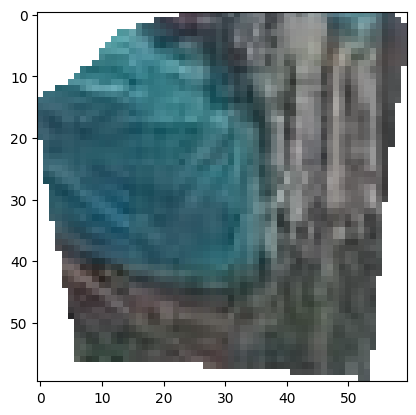

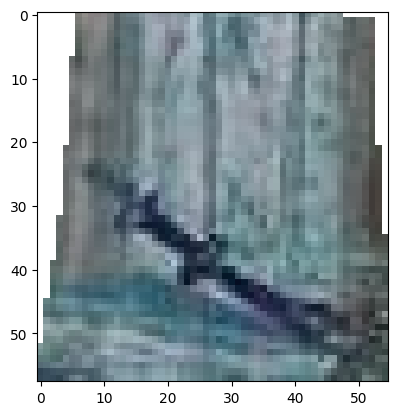

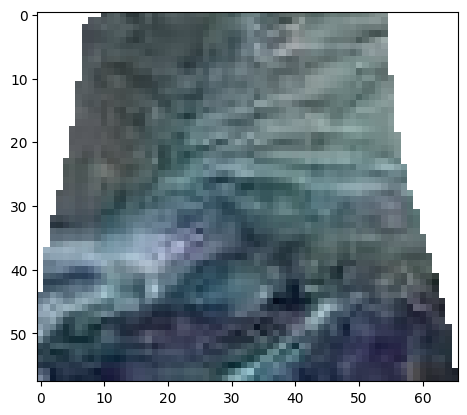

------------------------------


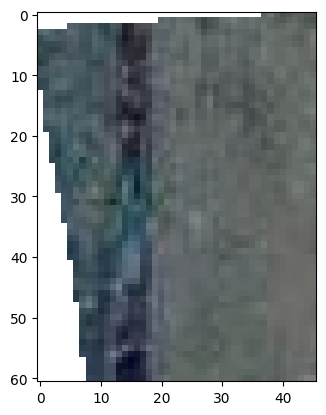

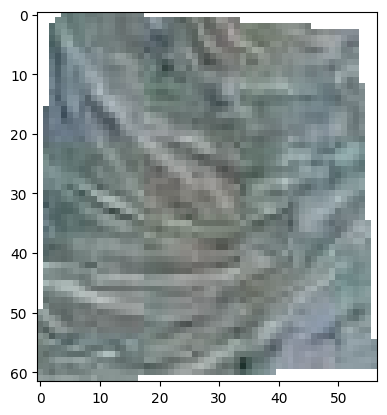

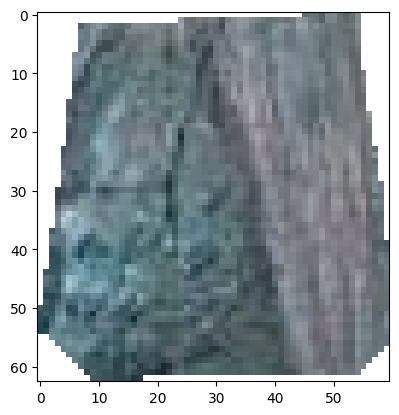

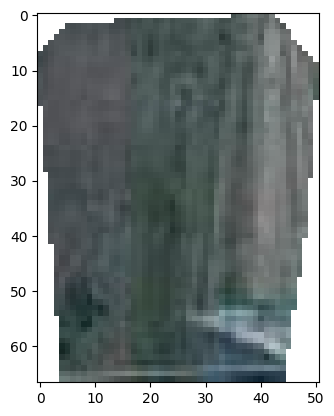

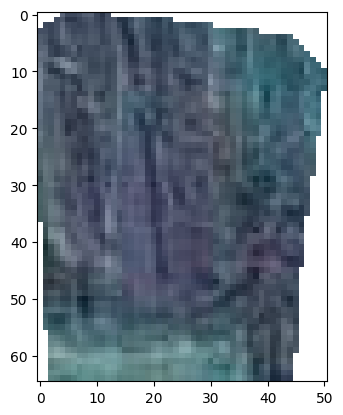

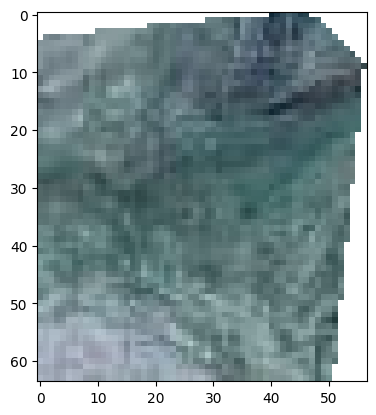

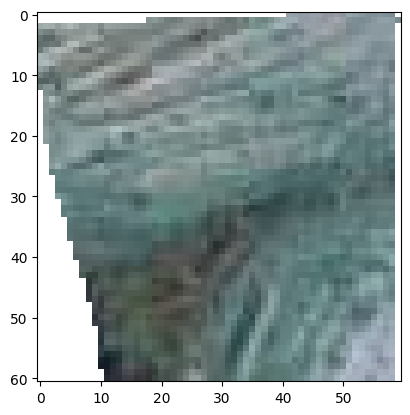

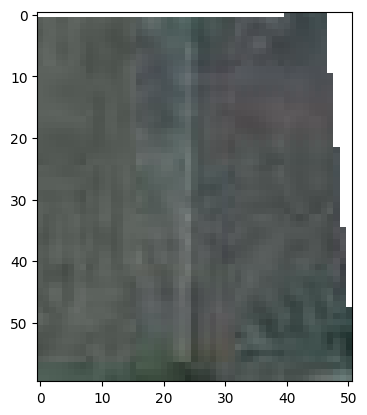

------------------------------


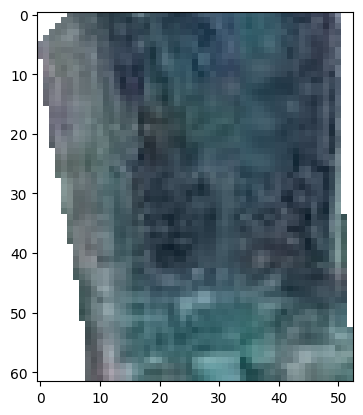

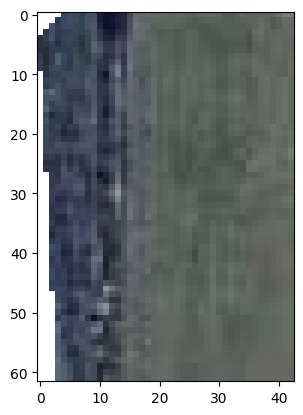

------------------------------


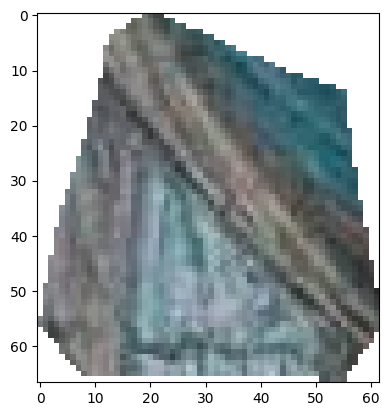

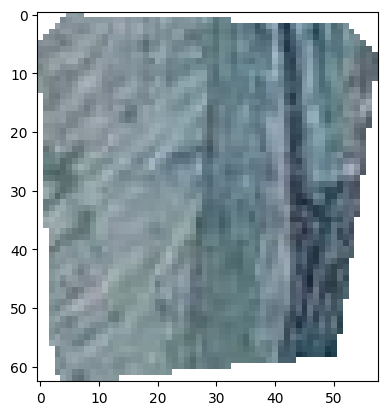

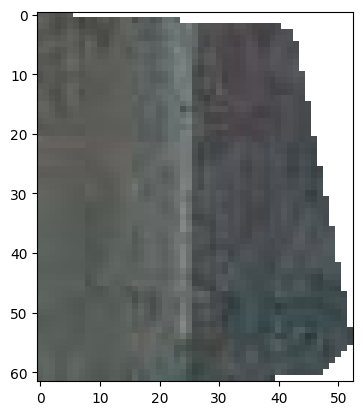

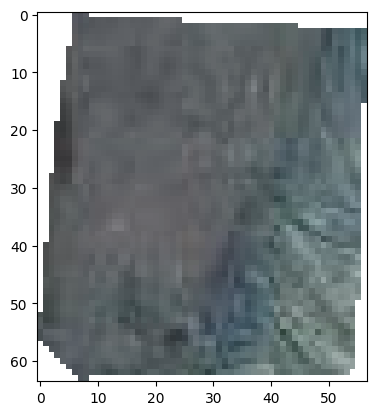

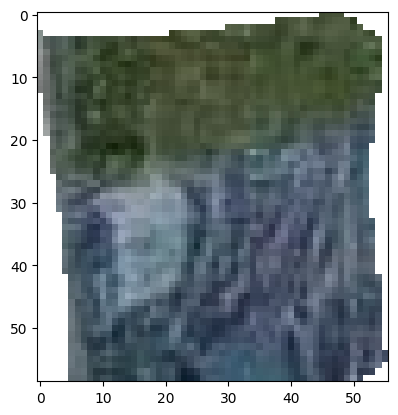

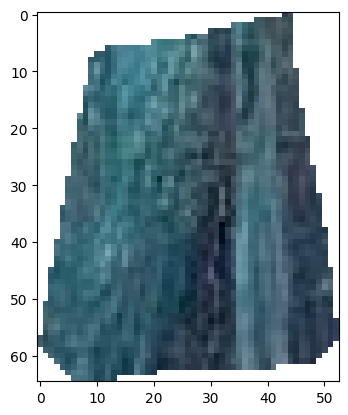

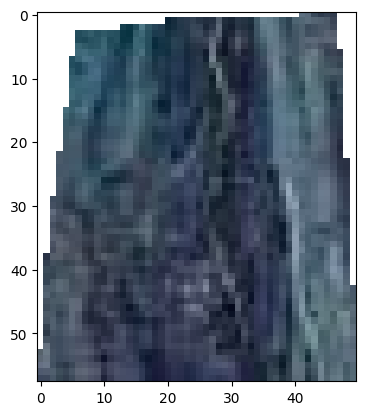

------------------------------


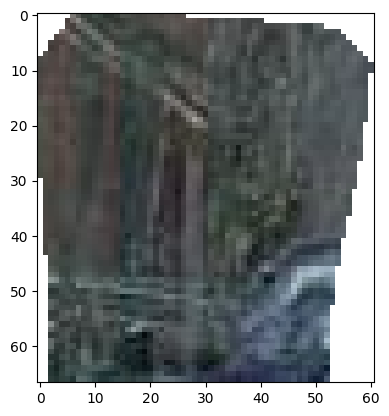

------------------------------


In [89]:
clusters = np.unique(cluster.labels_)

list_images = []

# Iterate through each file and read its content
for file in files:
    file_path = os.path.join(directory, file)
    img = cv.imread(file_path, cv.IMREAD_UNCHANGED)
    list_images.append(img)

for _ in clusters:
    images_idx = np.where(cluster.labels_ == _)[0].tolist()
    for image_idx in images_idx:
        plt.imshow(list_images[image_idx])
        plt.show()
    print("------------------------------")

In [78]:
np.where(cluster.labels_ == 0)

(array([ 1, 18, 19], dtype=int64),)